In [1]:
import os
import numpy as np
import torch

import cv2
from skimage.metrics import structural_similarity as compare_ssim
from runpy import run_path


In [ ]:
!pip install einops
!pip install hdf5storage
import hdf5storage
import pandas as pd 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
def load_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    parameters = {'inp_channels':1, 'out_channels':1, 'dim':48, 'num_blocks':[4,6,6,8], 'num_refinement_blocks':4, 'heads':[1,2,4,8], 'ffn_expansion_factor':2.66, 'bias':False, 'LayerNorm_type':'BiasFree', 'dual_pixel_task':False}
    load_arch = run_path('/content/drive/MyDrive/SRFP/Restormer/basicsr/models/archs/restormer_arch.py')      #os.path.join('models', 'restormer_arch.py'))
    model = load_arch['Restormer'](**parameters)
    checkpoint = torch.load('/content/drive/MyDrive/SRFP/DPIR/model_zoo/gaussian_gray_denoising_sigma50.pth')  #('/content/drive/MyDrive/SRFP/DPIR/model_zoo/gaussian_gray_denoising_sigma50.pth') #('/content/drive/MyDrive/SRFP/DPIR/model_zoo/gaussian_gray_denoising_blind.pth')  #torch.load('/content/drive/MyDrive/SRFP/DPIR/model_zoo/gaussian_color_denoising_blind.pth')
    model.load_state_dict(checkpoint['params'], strict=True)
    #model.load_state_dict(torch.load(model_path), strict=True) #load the weights of the network
    model.eval()# set to training modet
    for k, v in model.named_parameters():

        v.requires_grad = False
    model = model.to(device)
    return model    

In [ ]:
def proj(im_input, minval, maxval):
    im_out = np.where(im_input > maxval, maxval, im_input)
    im_out = np.where(im_out < minval, minval, im_out)
    return im_out

def psnr(x, y):
    norm2 = np.mean((x - y) ** 2)
    psnrval = -10 * np.log10(norm2)
    return psnrval

In [ ]:
import time
def pnp_fbs_deblur(model, im_input, im_ref, mask, **opts):

    rho = opts.get('rho', 1.0) 
    maxitr = opts.get('maxitr', 100)
    verbose = opts.get('verbose',1)
    sigma = opts.get('sigma', 5)
    max_list = []
    check_list = []

    """ Initialization. """

    m, n = im_ref.shape
    index = np.nonzero(mask)

    w = len(mask[0])
    r = int((w - 1) / 2)
    im_input = cv2.copyMakeBorder(im_input, r, r, r, r, borderType=cv2.BORDER_WRAP)
    y = cv2.filter2D(im_input, -1, mask)
    y = y[r:r+m, r:r+n]
    im_input = im_input[r:r+m, r:r+n]

    filtfft = np.square(np.absolute(np.fft.fft2(mask, y.shape)))

    x = 0.5 * np.ones((m,n), dtype=np.float64)

    """ Main loop. """
    for i in range(maxitr):

        xold = np.copy(x)
        """ Update gradient. """

        vf = np.fft.fft2(xold)
        gradx = np.real(np.fft.ifft2(np.multiply(vf, filtfft))) - y

        """ Denoising step. """

        xtilde = np.copy(xold - rho * gradx)

        # This is the denoiser part
        xtilde_torch = np.reshape(xtilde, (1,1,m,n))
        xtilde_torch = torch.from_numpy(xtilde_torch).type(torch.FloatTensor).cuda()
        r = model(xtilde_torch).cpu().numpy()
        r = np.reshape(r, (m,n))
        x = 0.5*r + 0.5*xtilde
        x = proj(x, 0.0, 1.0)

        """ Monitoring. """
        max_list.append( psnr(x,im_ref) )
        index = max_list.index(np.max(max_list))
        check_list.append((i+1,psnr(x, im_ref),time.time()))
        if verbose:
            print("i: {}, \t psnr: {}"\
                  .format(i+1, psnr(x,im_ref)))

    return x,np.max(max_list),index,check_list

In [ ]:
def iterate(input_array, rho_ = 1.0, itr_ = 50):
    with torch.no_grad():
        
        im_orig = input_array
        m,n = im_orig.shape

        # ---- blur the image
        kernel = cv2.getGaussianKernel(25, 1.6)
        mask = np.outer(kernel, kernel.transpose())
        w = len(mask[0])
        r = int((w - 1) / 2)
        im_orig = cv2.copyMakeBorder(im_orig, r, r, r, r, borderType=cv2.BORDER_WRAP)
        im_blur = cv2.filter2D(im_orig, -1, mask)
        im_blur = im_blur[r:r+m, r:r+n]
        im_orig = im_orig[r:r+m, r:r+n]

        # ---- add noise -----
        noise_level = 7.65 /255.0#10.0 /255.0
        gauss = np.random.normal(0.0, noise_level, im_blur.shape)
        im_noisy = im_blur + gauss
        im_noisy = proj(im_noisy, 0, 1)

        # ---- set options -----
        sigma = 25
        rho = rho_
        maxitr = itr_
        opts = dict(sigma=sigma, rho=rho, maxitr=maxitr, verbose=True)
        
        # ---- load the model ----
        model = load_model() #load_model("DnCNN", sigma)

        # ---- plug and play -----
        out ,max, index,check_list = pnp_fbs_deblur(model, im_noisy, im_orig, mask, **opts)

        # ---- results ----
        psnr_ours = psnr(out, im_orig)
        ssim_ours = compare_ssim(out, im_orig, data_range=1.)
        print('sigma = {}, rho = {} - PNSR: {}, SSIM = {} Max : {}, Index : {}'.format(sigma, rho, psnr_ours, ssim_ours,max,index))
    return   (out ,sigma, rho, psnr_ours, ssim_ours,max,index,check_list)

In [ ]:
import math
import os
def calculate_psnr(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [ ]:
def driver(rho_, itr_):
  temp = '/content/drive/MyDrive/SRFP/DPIR/testsets/set3c/starfish.png'
  im_orig = cv2.imread(temp)/255.0

  #------------------------- splitting each channel 
  im_orig_r = im_orig[:,:,0]
  im_orig_g = im_orig[:,:,1]
  im_orig_b = im_orig[:,:,2]

  #-------------------------Predicting each channel 
  sum = 0
  avg_psnr = 0 
  _rho_ = rho_
  _itr_ = itr_
  # out_r , sigma, rho, psnr_ours, ssim_ours,max,index = iterate(im_orig_r,rho_ = _rho_, itr_ = _itr_) ; sum = sum + index  
  # avg_psnr = avg_psnr + max
  out_g , sigma, rho, psnr_ours, ssim_ours,max,index,check_list = iterate(im_orig_g,rho_ = _rho_, itr_ = _itr_) ; sum = sum + index 
  # avg_psnr = avg_psnr + max
  # out_b , sigma, rho, psnr_ours, ssim_ours,max,index = iterate(im_orig_b,rho_ = _rho_, itr_ = _itr_) ; sum = sum + index  
  # avg_psnr = avg_psnr + max

  # print('give_itr',math.ceil(sum/3), 'with_iter_set ****',avg_psnr/3)

  #-------------------------Merginng all channels together
  im_recon = np.ones(im_orig.shape, out_g.dtype)
  im_recon[:,:,0] = np.uint8((out_g*255.0).round())
  im_recon[:,:,1] = np.uint8((out_g*255.0).round())
  im_recon[:,:,2] = np.uint8((out_g*255.0).round()) 
  im_recon = im_recon.astype('uint8')

  #-------------------------Psnr
  psnr = calculate_psnr(im_recon,cv2.imread(temp))
  print('current psnr',psnr)
  #cv2.imwrite('LeavesIBLINDrho'+str(rho_)+'itr'+str(itr_)+str(psnr) +'.png', im_recon)
  print(check_list)


In [ ]:
import pandas as pd
df = pd.DataFrame(l, columns =['iter', 'psnr', 'time'])


In [ ]:
df

,iter,psnr,time
0,1,17.058271,0.000000
1,2,19.329939,0.198344
2,3,20.858098,0.394855
3,4,22.318956,0.590146
4,5,23.134680,0.785338
5,6,24.044197,0.980193
6,7,24.407248,1.177154
7,8,24.934404,1.373523
8,9,25.072474,1.572014
9,10,25.372101,1.767159


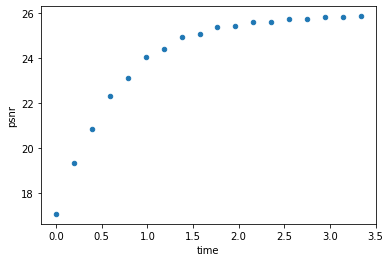

In [ ]:
df.plot(x = 'time',y ='psnr',kind='scatter' )

In [ ]:
df.describe()

,iter,psnr,time
count,18.000000,18.000000,18.000000
mean,9.500000,24.010887,1.668720
std,5.338539,2.555388,1.047261
min,1.000000,17.058271,0.000000
25%,5.250000,23.362059,0.834052
50%,9.500000,25.222288,1.669586
75%,13.750000,25.709528,2.502917
max,18.000000,25.872936,3.335195


In [ ]:
for rho in [1.8,1.9,2.]:
  driver(rho_ = rho, itr_ = 50)



sigma = 25, rho = 1.8 - PNSR: 22.056920181647868, SSIM = 0.7665740970882393 Max : 22.48875204322387, Index : 20
sigma = 25, rho = 1.8 - PNSR: 23.177599800376854, SSIM = 0.7364550462080816 Max : 24.500448475295325, Index : 14
sigma = 25, rho = 1.8 - PNSR: 22.464453518381973, SSIM = 0.7727754509042735 Max : 23.180862880094146, Index : 16
give_itr 17 with_iter_set **** 23.390021132871112
current psnr 22.540709118027998
sigma = 25, rho = 1.9 - PNSR: 21.96099328518583, SSIM = 0.764610792820944 Max : 22.546450695988206, Index : 20
sigma = 25, rho = 1.9 - PNSR: 23.125794489641095, SSIM = 0.7362417148183248 Max : 24.351128266910788, Index : 18
sigma = 25, rho = 1.9 - PNSR: 22.325396322273114, SSIM = 0.7677305442559595 Max : 23.219180254750924, Index : 18
give_itr 19 with_iter_set **** 23.37225307254997
current psnr 22.443155800033715
sigma = 25, rho = 2.0 - PNSR: 21.914104016368196, SSIM = 0.7806281972015117 Max : 22.155032706328587, Index : 30
sigma = 25, rho = 2.0 - PNSR: 22.21282556044988, 